In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter

In [3]:

import pandas as pd

df = pd.read_excel('merged-data-COMBINED.xlsx')

basket_totals = df.groupby('Basket_ID').agg({
    'Sum_Value': 'sum', 
    'Sum_Units': 'sum', 
    'Card_ID': 'first', 
    'Age':'first',
    'Gender':'first',
    'MaritalStatus':'first',
    'HouseholdSize':'first',
    'Children':'first',
    'Date' : 'first',
    'CategoryDDescription' : lambda x: '|'.join(x)
    }).reset_index()


loyalty_baskets = basket_totals[basket_totals['Card_ID'].notnull()]
non_loyalty_baskets = basket_totals[basket_totals['Card_ID'].isnull()]

basket_frequencies = loyalty_baskets.groupby(['Card_ID', 'Basket_ID']).size().reset_index(name='Basket_Frequency')
loyalty_baskets = pd.merge(loyalty_baskets, basket_frequencies.groupby('Card_ID')['Basket_Frequency'].count().reset_index(name='Basket_Frequency'), on='Card_ID')






In [5]:
# print the results
loyalty_baskets

#non_loyalty_baskets

,Basket_ID,Sum_Value,Sum_Units,Card_ID,Age,Gender,MaritalStatus,HouseholdSize,Children,Date,CategoryDDescription,Basket_Frequency
0,1089674689,3.590022,6,9.160002e+12,61.0,Male,None,3.0,NaN,2013-03-04,fresh milk |kitcher roll|salt|cinamon,11
1,1093497639,16.221247,7,9.160002e+12,61.0,Male,None,3.0,NaN,2013-03-15,SHAMPOO|soft cheese |fresh milk |pickle|white ...,11
2,1094397183,8.040029,5,9.160002e+12,61.0,Male,None,3.0,NaN,2013-03-19,fresh milk |dishwasher|greek coffe,11
3,1097158750,5.611592,4,9.160002e+12,61.0,Male,None,3.0,NaN,2013-03-28,soft cheese |fresh milk |pasta|white cheese,11
4,1101829337,6.078738,5,9.160002e+12,61.0,Male,None,3.0,NaN,2013-04-11,LIMITED DURATION|fresh milk |poultry|BANANAS|w...,11
...,...,...,...,...,...,...,...,...,...,...,...,...
10283,1109174239,10.690007,2,9.162003e+12,53.0,Female,Married,4.0,NaN,2013-05-02,familly |SPECIAL COOKING POOLS,1
10284,1109174332,45.052502,4,9.164005e+12,71.0,Male,None,1.0,0.0,2013-05-02,TOMATOES|POTATOES|PEARS|kid,1
10285,1109174351,3.000000,10,9.162008e+12,43.0,Female,None,1.0,0.0,2013-05-02,wafers,1
10286,1109175661,9.860044,6,9.164010e+12,39.0,Female,None,3.0,2.0,2013-05-02,tea|mushrooms |shower gels|sour cream|easter,1


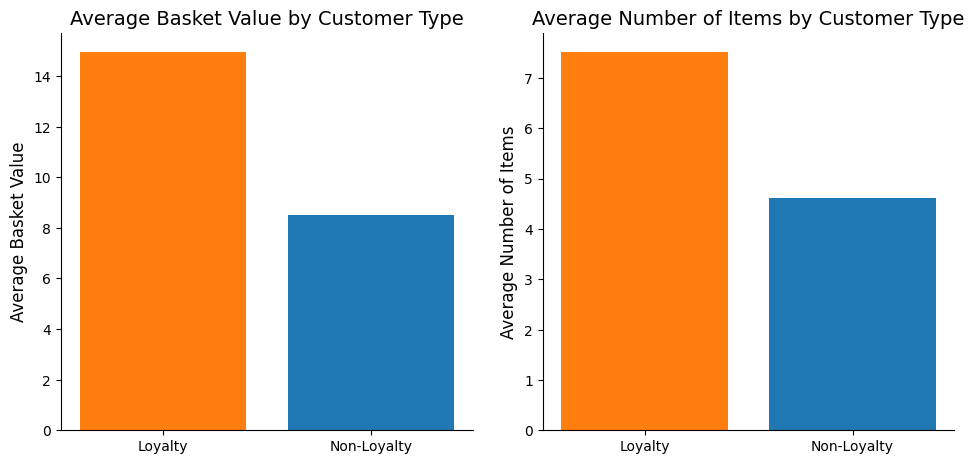

In [4]:

loyalty_avg = loyalty_baskets[['Sum_Value', 'Sum_Units']].mean()
non_loyalty_avg = non_loyalty_baskets[['Sum_Value', 'Sum_Units']].mean()

loyalty_color = '#ff7f0e'  # orange
non_loyalty_color = '#1f77b4'  # blue

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


ax1.bar(['Loyalty', 'Non-Loyalty'], [loyalty_avg['Sum_Value'], non_loyalty_avg['Sum_Value']], color=[loyalty_color, non_loyalty_color])
ax1.set_ylabel('Average Basket Value', fontsize=12)
ax1.set_title('Average Basket Value by Customer Type', fontsize=14)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


ax2.bar(['Loyalty', 'Non-Loyalty'], [loyalty_avg['Sum_Units'], non_loyalty_avg['Sum_Units']], color=[loyalty_color, non_loyalty_color])
ax2.set_ylabel('Average Number of Items', fontsize=12)
ax2.set_title('Average Number of Items by Customer Type', fontsize=14)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

fig.tight_layout(pad=2)
plt.show()


In [5]:

loyalty_baskets['Date'] = pd.to_datetime(loyalty_baskets['Date'])

last_purchase_date = loyalty_baskets.groupby('Card_ID')['Date'].max().reset_index(name='LastPurchaseDate')

loyalty_baskets = pd.merge(loyalty_baskets, last_purchase_date[['Card_ID', ]], on='Card_ID', how='left')


march_customers = set(loyalty_baskets[loyalty_baskets['Date'] < '2013-04-01']['Card_ID'].unique())


apr_may_customers = set(loyalty_baskets[loyalty_baskets['Date'] >= '2013-04-01']['Card_ID'].unique())


churned_customers = march_customers.difference(apr_may_customers)
churned_percent = len(churned_customers) / len(march_customers) * 100

print(f"Churned customer percentage: {churned_percent:.2f}%")

Churned customer percentage: 28.56%


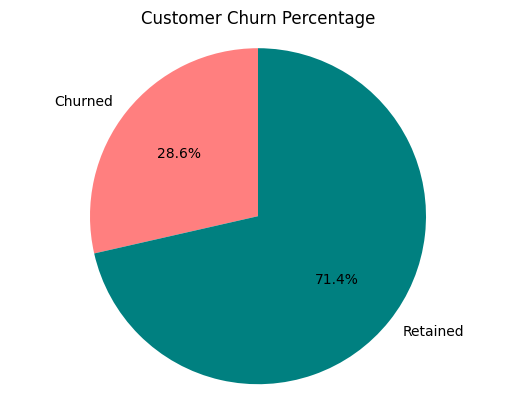

In [6]:

labels = ['Churned', 'Retained']
sizes = [churned_percent, 100-churned_percent]
colors = ['#FF7F7F','#008080']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

plt.title('Customer Churn Percentage')
plt.show()


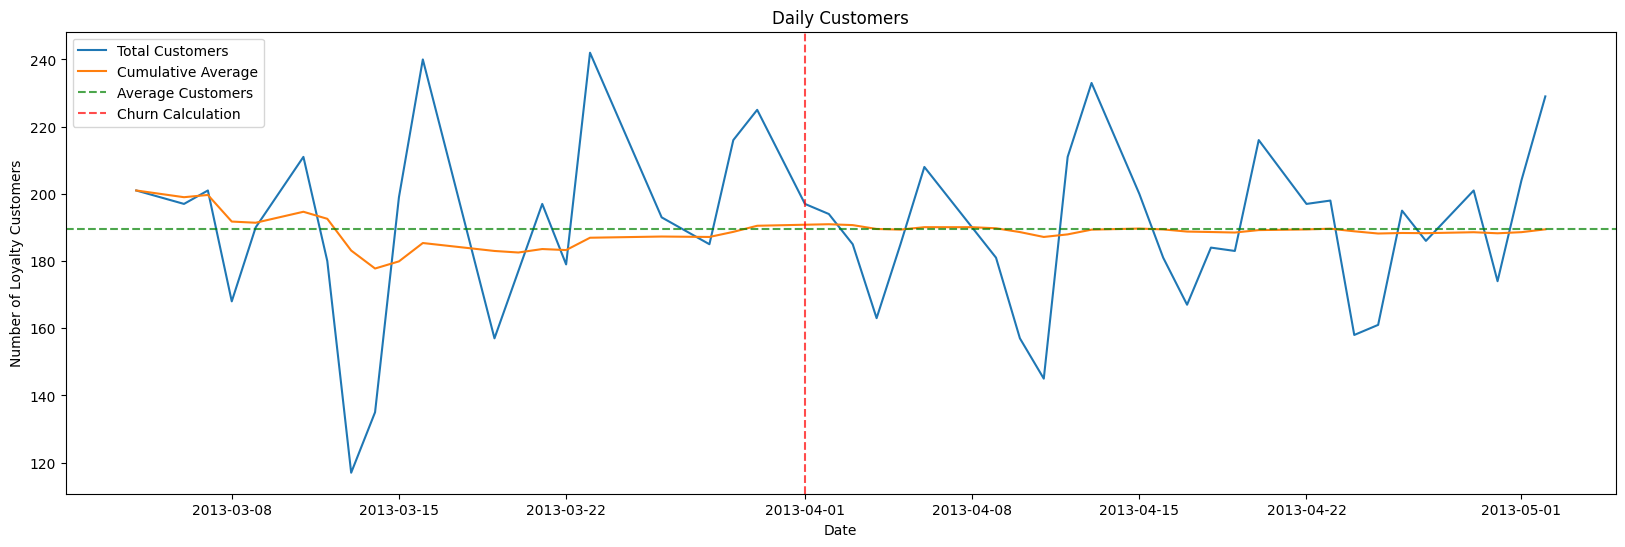

In [23]:
daily_customers = loyalty_baskets.groupby('Date')['Card_ID'].nunique().reset_index(name='NumCustomers')

daily_customers['BeforeChurn'] = daily_customers['Date'] < pd.to_datetime('2013-04-01')

daily_customers['CumulativeAvgAll'] = daily_customers['NumCustomers'].cumsum() / (daily_customers.index + 1)

average_customers = daily_customers['NumCustomers'].mean()

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(daily_customers['Date'], daily_customers['NumCustomers'], label='Total Customers')
ax.plot(daily_customers['Date'], daily_customers['CumulativeAvgAll'], label='Cumulative Average')
ax.axhline(y=average_customers, color='green', linestyle='--', alpha=0.7, label='Average Customers')
ax.axvline(pd.to_datetime('2013-04-01'), color='red', linestyle='--', alpha=0.7, label='Churn Calculation')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Loyalty Customers')
ax.set_title('Daily Customers')
ax.legend()

plt.show()


In [21]:
cumulative_sum = 0
cumulative_count = 0
cumulative_averages = []
for i, row in daily_customers.iterrows():
    if row['BeforeChurn']:
        cumulative_sum += row['NumCustomers']
        cumulative_count += 1
    cumulative_avg = cumulative_sum / cumulative_count if cumulative_count > 0 else 0
    cumulative_averages.append(cumulative_avg)

daily_customers['ManualCumulativeAvg'] = cumulative_averages


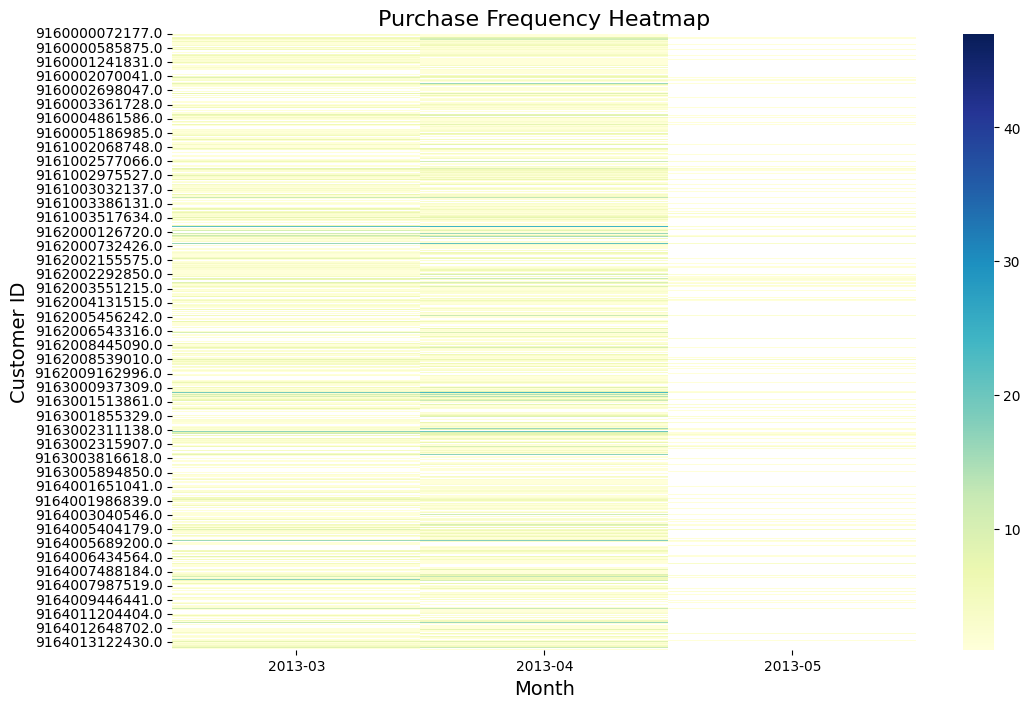

In [8]:

loyalty_baskets['Date'] = pd.to_datetime(loyalty_baskets['Date'])

loyalty_baskets['Month'] = loyalty_baskets['Date'].dt.to_period('M')

purchases = loyalty_baskets.pivot_table(index='Card_ID', columns='Month', values='CategoryDDescription', aggfunc='count')

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(purchases, cmap='YlGnBu', ax=ax)

ax.set_title('Purchase Frequency Heatmap', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Customer ID', fontsize=14)


plt.show()

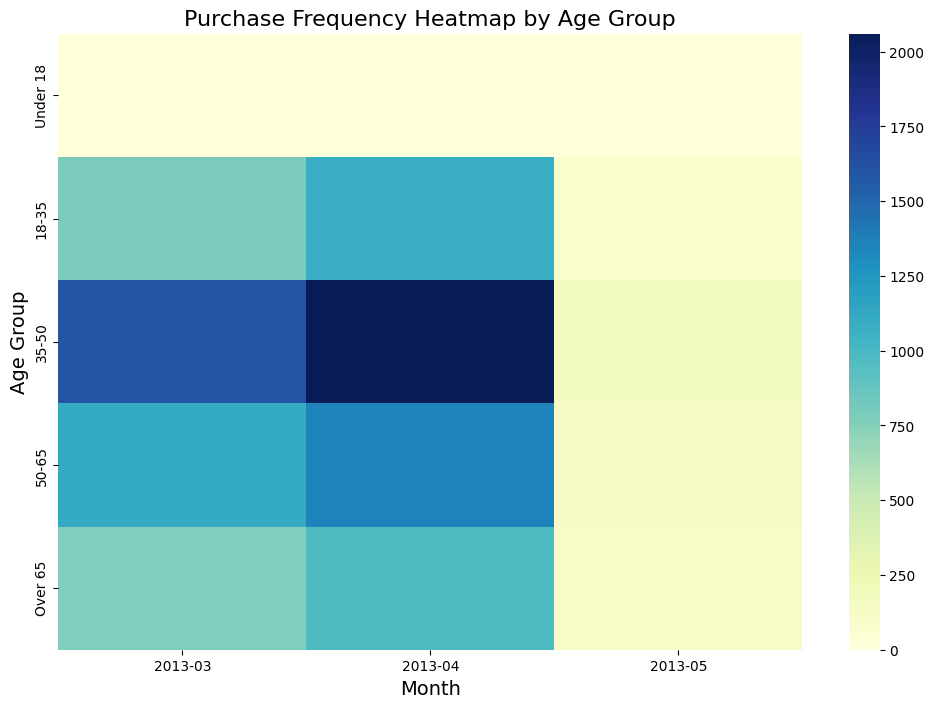

In [9]:

loyalty_baskets['Age_Group'] = pd.cut(loyalty_baskets['Age'], bins=[0, 18, 35, 50, 65, 100], labels=['Under 18', '18-35', '35-50', '50-65', 'Over 65'])

purchases = loyalty_baskets.pivot_table(index='Age_Group', columns='Month', values='CategoryDDescription', aggfunc='count')


fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(purchases, cmap='YlGnBu', ax=ax)

ax.set_title('Purchase Frequency Heatmap by Age Group', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Age Group', fontsize=14)


plt.show()

In [10]:

tokens = loyalty_baskets['CategoryDDescription'].str.split('|')


all_tokens = [token for sublist in tokens for token in sublist]

token_counts = Counter(all_tokens)

sorted_counts = token_counts.most_common()

print(sorted_counts[:10])

[('fresh milk ', 2137), ('high pasterized ', 1613), ('white', 1516), ('soft cheese ', 1277), ('LIMITED DURATION', 1161), ('cola', 1136), ('tomato', 1030), ('BANANAS', 939), ('POTATOES', 924), ('poweder', 884)]


In [11]:

top_products = loyalty_baskets['CategoryDDescription'].str.split('|', expand=True).stack().reset_index(drop=True)
top_products = top_products.value_counts().head(10).index.tolist()

df_top_products = df[df['CategoryDDescription'].str.contains('|'.join(top_products))]


grouped_demographics = df_top_products.groupby(['Age', 'Gender', 'MaritalStatus', 'HouseholdSize', 'Children']).agg({
    'Sum_Value': 'mean',
    'Sum_Units': 'mean'
}).reset_index()

print(grouped_demographics)

      Age  Gender   MaritalStatus  HouseholdSize  Children  Sum_Value  \
0    20.0  Female         Married            3.0       1.0   1.578581   
1    24.0  Female  Single (Alone)            1.0       0.0   1.540000   
2    25.0  Female         Married            1.0       0.0   2.320235   
3    25.0  Female  Single (Alone)            1.0       0.0   1.490007   
4    27.0  Female         Married            2.0       0.0   2.034043   
..    ...     ...             ...            ...       ...        ...   
325  85.0    Male         Married            2.0       1.0   1.958285   
326  86.0  Female         Married            5.0       2.0   1.089861   
327  86.0    Male         Married            1.0       0.0   1.876899   
328  88.0  Female         Married            1.0       0.0   2.996850   
329  90.0    Male         Married            2.0       1.0   1.306667   

     Sum_Units  
0     1.285714  
1     1.000000  
2     1.000000  
3     1.000000  
4     1.000000  
..         ...  
325 

In [12]:

fresh_milk_baskets = loyalty_baskets[loyalty_baskets['CategoryDDescription'].str.contains('fresh milk')]

fresh_milk_demographics = fresh_milk_baskets.groupby(['Age', 'Gender']).agg({'Sum_Value': 'mean'})

fresh_milk_demographics = fresh_milk_demographics.reset_index()

print(fresh_milk_demographics)

      Age  Gender  Sum_Value
0    19.0  Female  25.822550
1    20.0  Female   5.330066
2    21.0    Male  10.066324
3    23.0  Female  21.937589
4    24.0  Female  31.611064
..    ...     ...        ...
127  85.0    Male   8.535021
128  86.0  Female  13.636032
129  88.0    Male  10.296029
130  90.0  Female   7.978870
131  90.0    Male   9.696493

[132 rows x 3 columns]
